In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import math
import warnings
from scipy import stats
warnings.filterwarnings("ignore")
sns.set_style('whitegrid')
%matplotlib inline

In [2]:
df = pd.read_csv(r'C://Users/Marco/Desktop/energy_star.csv')

### 1. Data Preperation

In [3]:
def convert(df):
    df = df.replace({'Not Available': np.nan})
    for col in list(df.columns):
        if ('ft²' in col or 'kBtu' in col or 'Metric Tons CO2e' in col or 'kWh' in col or 'therms' in col or 'gal' in col or 'Score' in col):
            df[col] = df[col].astype(float)
    return df

In [4]:
df = convert(df)

In [5]:
def missing_values(df):
    mis_val = df.isnull().sum()
    mis_val_pct = mis_val / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_pct], axis=1)
    mis_val_table = mis_val_table.rename(columns={0: 'Missing Values', 1: 'Pct. of Total values'})
    mis_val_table = mis_val_table[mis_val_table.iloc[:,1] !=0].sort_values('Pct. of Total values', ascending=False).round(4)
    return mis_val_table

In [6]:
mis_table = missing_values(df)
mis_table

,Missing Values,Pct. of Total values
Fuel Oil #1 Use (kBtu),11737,0.9992
Diesel #2 Use (kBtu),11730,0.9986
Address 2,11539,0.9824
Fuel Oil #5 & 6 Use (kBtu),11152,0.9494
District Steam Use (kBtu),10810,0.9203
Fuel Oil #4 Use (kBtu),10425,0.8875
3rd Largest Property Use Type - Gross Floor Area (ft²),10262,0.8737
3rd Largest Property Use Type,10262,0.8737
Fuel Oil #2 Use (kBtu),9165,0.7803
2nd Largest Property Use Type,8005,0.6815


In [7]:
def drop_missing(df):
    mis_cols = list(mis_table.loc[mis_table['Pct. of Total values'] > 0.2].index)
    df.drop(columns=mis_cols, inplace=True)
    cols = len(df.columns)
    df.dropna(thresh=math.ceil(cols*0.8), inplace=True)
    #drop columns with no information gain
    drop_cols = ['Property Name', 'Parent Property Name', 'Parent Property Id', 'BBL - 10 digits', 'NYC Building Identification Number (BIN)', 'Address 1 (self-reported)', 'Postal Code', 'Street Number', 'Street Name', 'Metered Areas (Energy)','NYC Borough, Block and Lot (BBL) self-reported', 'DOF Benchmarking Submission Status', 'Water Required?','Release Date', 'Primary Property Type - Self Selected', 'List of All Property Use Types at Property', 'Order', 'Property Id', 'Latitude', 'Longitude', 'Community Board', 'Council District', 'Census Tract']
    df.drop(columns=drop_cols, inplace=True)
    return df

In [8]:
df = drop_missing(df)

In [9]:
def convert_year(df):
    df['year_cat'] = np.nan
    year_intervals = [[1900+i, 1900+i+10] for i in np.arange(0,120,10).tolist()]
    year_intervals.insert(0, [min(df['Year Built']), 1900])
    for i in [df]:
        for year in year_intervals:
            df.loc[(df['Year Built'] > year[0]) & (df['Year Built'] <= year[1]), 'year_cat'] = f'{year[0]}_{year[1]}'
    return df

In [10]:
df = convert_year(df)

In [11]:
def rename_score():
    df.rename(columns={'ENERGY STAR Score': 'Score'}, inplace=True)
    return df 

df = rename_score()

##### 1.1 Functions for categorical variables

In [12]:
def kde_plot(df, feature):
    cols = df[feature].value_counts()[:4].index.tolist()
    plt.figure(figsize=(6,6))
    for cat in cols:
        subset = df[df[feature] == cat]
        p = sns.kdeplot(subset['Score'].dropna(), label=cat, shade=False, alpha=0.8)
        p.set(title = f'Energy Star Score Distribution of {feature} for 4 most frequent categories')
    plt.show()

In [13]:
def categorical_eda(df, feature, print_df=True):
    group_df = df.groupby(feature)['Score'].mean().sort_values(ascending=False)[:10].reset_index()
    value_df = df[f'{feature}'].value_counts(normalize=True)[:10].reset_index()
    value_df.rename(columns={'index': f'{feature}', f'{feature}': 'pct.'}, inplace=True)
    eda_df = pd.merge(value_df, group_df, on=f'{feature}', how='outer')
    if print_df == True:
        print(eda_df)
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(14,6))
    ax1 = sns.barplot(x=feature, y='Score', data=group_df, palette='Reds', ax=ax1)     
    ax1.tick_params(axis='x', labelrotation = 90)
    ax1.set(title='Average Score by Subcategory')
    ax2 = sns.barplot(x=f'{feature}', y='pct.', data=eda_df, palette='Blues_d', ax=ax2)
    ax2.set(title='Frequency by subcategory')
    ax2.tick_params(axis='x', labelrotation = 90)
    ax3 = kde_plot(df, feature)
    plt.show()

##### 1.2 Functions for numerical variables

In [14]:
def remove_outliers(df, feature):
        first_quartile = df[feature].describe()['25%']
        third_quartile = df[feature].describe()['75%']
        iqr = third_quartile - first_quartile
        df_remove = df.loc[(df[feature] > (first_quartile - 10*iqr)) & (df[feature] < (third_quartile + 10*iqr))]
        df_remove.dropna(subset=[feature, 'Score'], inplace=True)
        feature = df_remove[feature]
        y = df_remove['Score']
        return y, feature

In [15]:
def corr(x, y):
    r = np.corrcoef(x, y)
    return r[0, 1]

In [16]:
def num_plots(df, feature, y_feature):
    r = corr(feature, y_feature)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,8))
    ax1 = sns.distplot(feature, ax=ax1)
    ax1.set(title='Distribution (Outliers removed)')
    ax2 = sns.scatterplot(x=feature, y=y_feature, ax=ax2)
    ax2.set(title='Relationship with Energy Star Score \n Correlation = {:.4f}'.format(r))  
    plt.show()

In [17]:
def collinear_features(df, feature):
    corr_vals = []

    corr_df = df.corr()[feature].reset_index()
    idx = corr_df.loc[corr_df[feature] > 0.8].index
    for i in idx:
        if corr_df.iloc[i][0] != feature:
            key = corr_df.iloc[i][0]
            val = corr_df.iloc[i][1]
            corr_dic = {'feature': key, 'correlation': val}
            corr_vals.append(corr_dic)

    corr_df = pd.DataFrame(corr_vals)
    return corr_df

## 2. EDA

#### 2.1 Energy Star Score

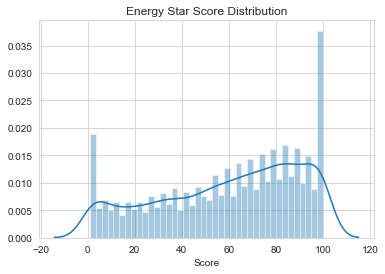

In [18]:
sns.distplot(df['Score'], bins=40)
plt.title('Energy Star Score Distribution')
plt.show()

In [19]:
df_corr1 = df.corr()['Score'].sort_values(ascending=False).reset_index()[1:]
df_num = df.select_dtypes(include=np.number)
df_corr2 = df_num[df_num.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]
df_corr2 = df_corr2.corr()['Score'].sort_values(ascending=False).reset_index()[1:]
df_corr = pd.merge(df_corr1, df_corr2, on='index', how='outer')
df_corr.rename(columns={'index': 'feature', 'Score_x': 'Corr. w/ outliers', 'Score_y': 'Corr. w/out outliers'}, inplace=True)
df_corr

,feature,Corr. w/ outliers,Corr. w/out outliers
0,Largest Property Use Type - Gross Floor Area (...,0.022217,-0.012984
1,Property GFA - Self-Reported (ft²),0.021094,-0.017839
2,DOF Gross Floor Area,0.003306,-0.059752
3,Number of Buildings - Self-reported,-0.017264,0.007870
4,Weather Normalized Site Natural Gas Intensity ...,-0.023128,-0.333376
5,Natural Gas Use (kBtu),-0.025923,-0.238831
6,Weather Normalized Site Natural Gas Use (therms),-0.025962,-0.236575
7,Direct GHG Emissions (Metric Tons CO2e),-0.026182,-0.268903
8,Occupancy,-0.028806,-0.001100
9,Weather Normalized Site EUI (kBtu/ft²),-0.035446,-0.109351


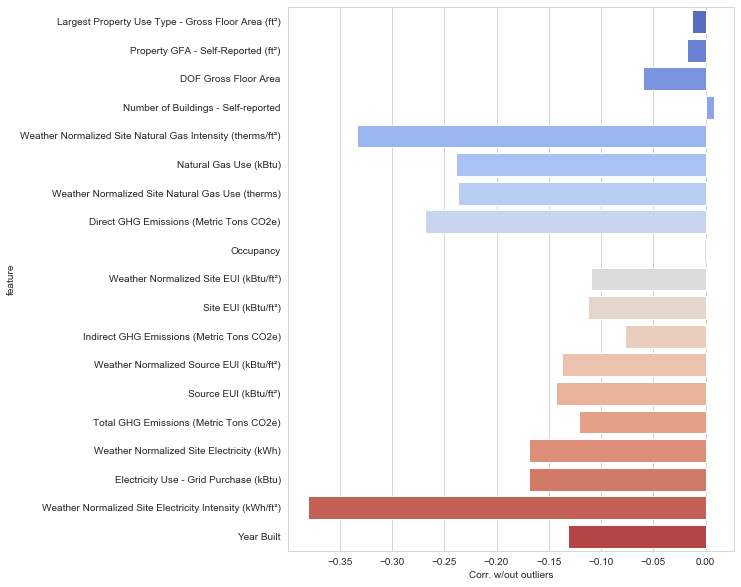

In [20]:
plt.figure(figsize=(8,10))
sns.barplot(x='Corr. w/out outliers', y='feature', data=df_corr, palette='coolwarm')
plt.show()

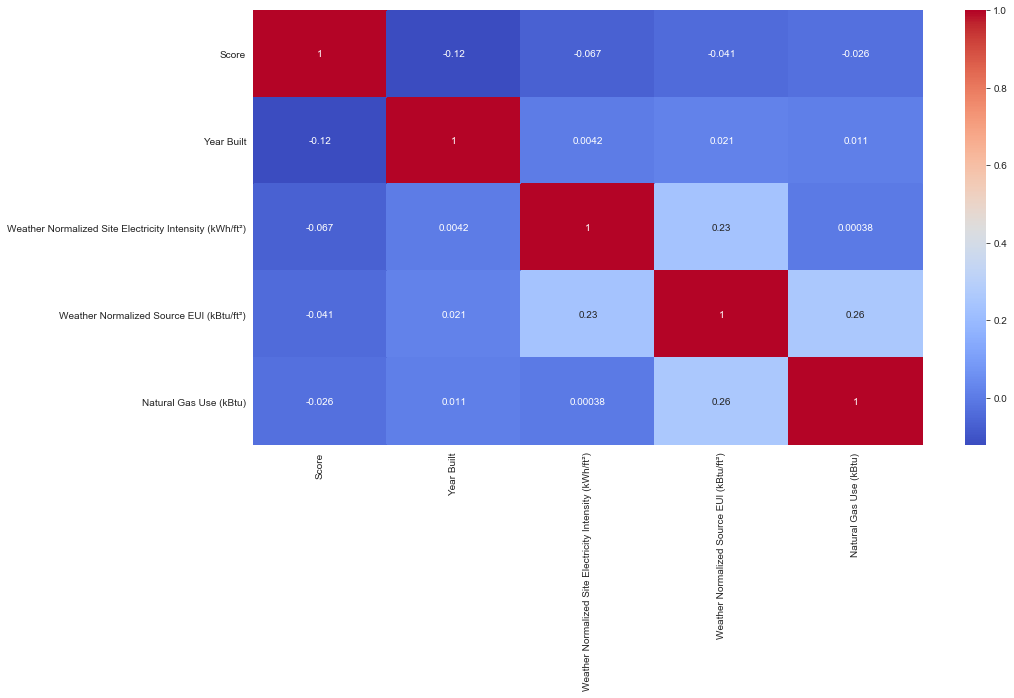

In [21]:
df_selected = df[['Score', 'Year Built', 'Weather Normalized Site Electricity Intensity (kWh/ft²)',
                 'Weather Normalized Source EUI (kBtu/ft²)', 'Natural Gas Use (kBtu)']]

plt.figure(figsize=(15,8))
sns.heatmap(df_selected.corr(), cmap='coolwarm', annot=True)
plt.show()

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11292 entries, 0 to 11745
Data columns (total 24 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   Borough                                                     11292 non-null  object 
 1   DOF Gross Floor Area                                        11292 non-null  float64
 2   Largest Property Use Type                                   11292 non-null  object 
 3   Largest Property Use Type - Gross Floor Area (ft²)          11292 non-null  float64
 4   Year Built                                                  11292 non-null  int64  
 5   Number of Buildings - Self-reported                         11292 non-null  int64  
 6   Occupancy                                                   11292 non-null  int64  
 7   Score                                                       9452 non-null   float64
 

#### 2.2 Borough

         Borough      pct.      Score
0      Manhattan  0.453507  58.678175
1       Brooklyn  0.198548  62.966531
2          Bronx  0.168349  57.698687
3         Queens  0.165958  61.022167
4  Staten Island  0.013638  61.240000


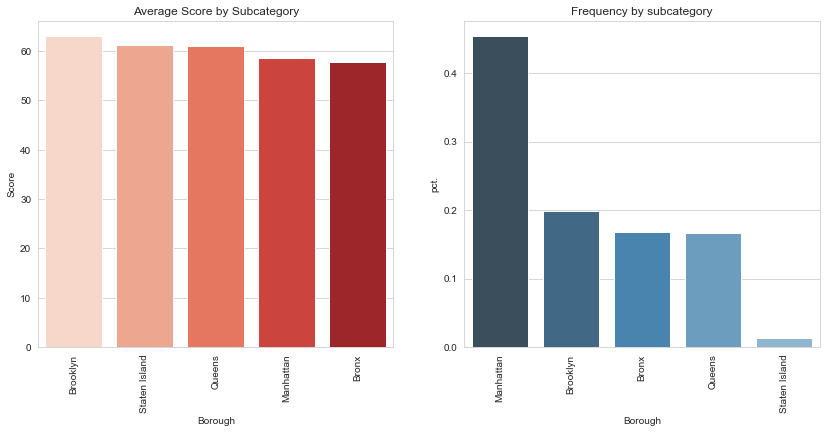

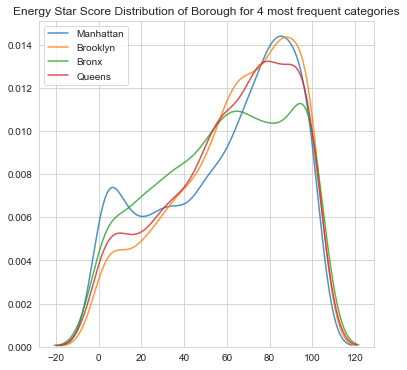

In [23]:
categorical_eda(df, 'Borough', print_df=True)

#### 2.3 DOF Gross Floor Area

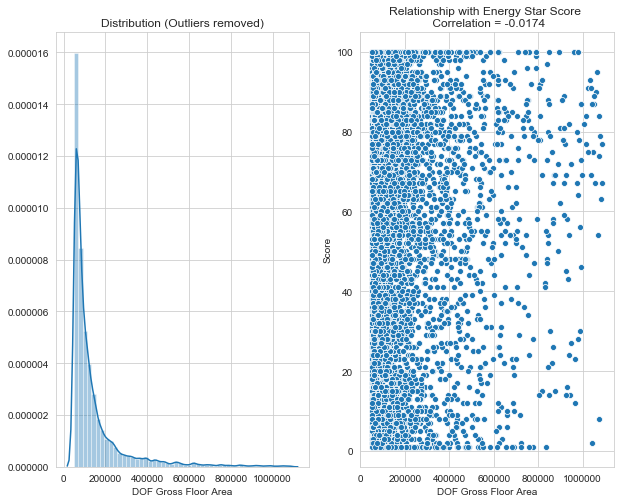

In [24]:
y_feature, feature = remove_outliers(df, 'DOF Gross Floor Area')
num_plots(df, feature, y_feature)

In [25]:
#collinear features

collinear_features(df, 'DOF Gross Floor Area')

,feature,correlation
0,Largest Property Use Type - Gross Floor Area (...,0.850258
1,Property GFA - Self-Reported (ft²),0.859871


#### 2.4 Largest Property Use Type

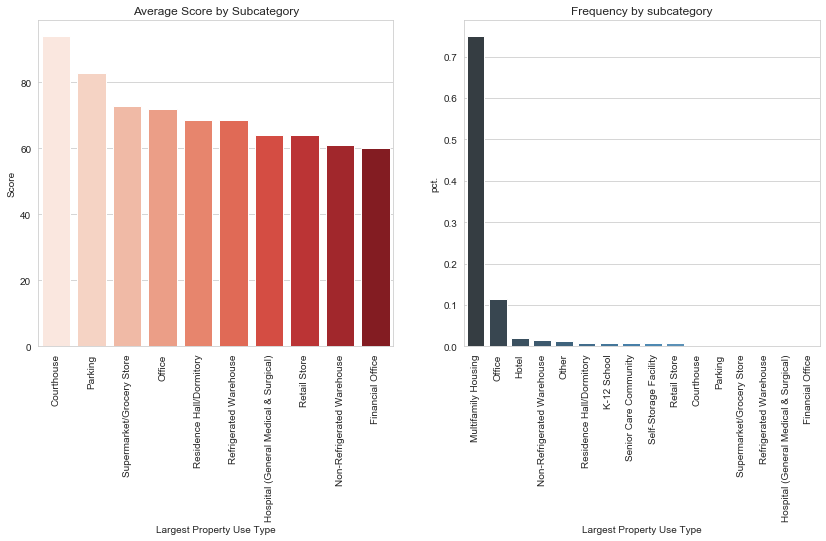

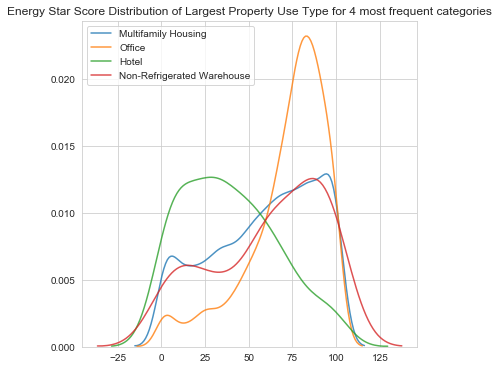

In [26]:
categorical_eda(df, 'Largest Property Use Type', print_df=False)

#### 2.5 Largest Property Use Type - Floor Area

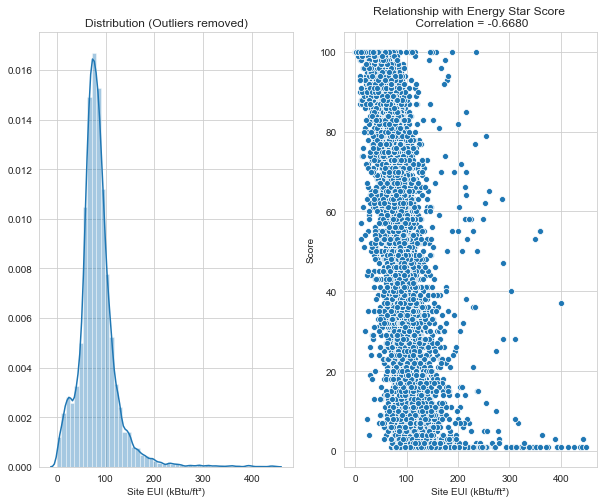

In [27]:
y_feature, feature = remove_outliers(df, 'Site EUI (kBtu/ft²)')
num_plots(df, feature, y_feature)

In [28]:
collinear_features(df, 'Site EUI (kBtu/ft²)')

,feature,correlation
0,Weather Normalized Site EUI (kBtu/ft²),0.999645
1,Weather Normalized Site Natural Gas Intensity ...,0.980949
2,Weather Normalized Source EUI (kBtu/ft²),0.996575
3,Source EUI (kBtu/ft²),0.994423


#### 2.6 Year Built

     year_cat      pct.      Score
0   1920_1930  0.239926  62.649693
1   1960_1970  0.121956  57.225532
2   1930_1940  0.116110  64.435897
3   1950_1960  0.104774  64.390458
4   2000_2010  0.076433        NaN
5   1910_1920  0.072713  62.894419
6   1940_1950  0.055974  62.146520
7   1980_1990  0.052254  53.816239
8   1900_1910  0.046143  62.978774
9   1970_1980  0.041715        NaN
10  2010_2020       NaN  66.281250
11  1600_1900       NaN  55.300000


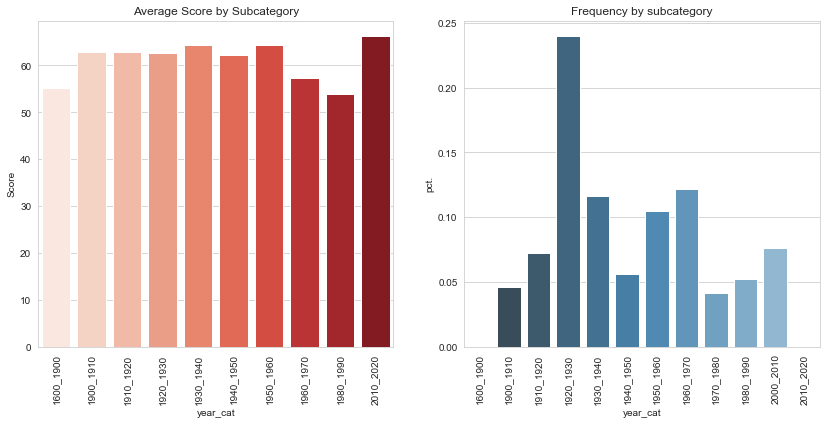

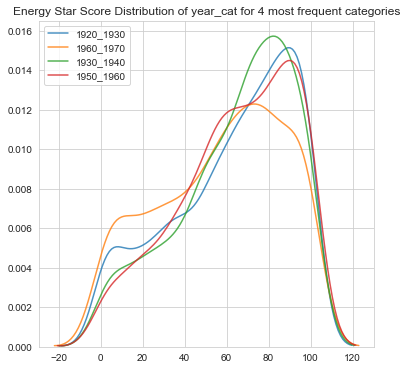

In [29]:
categorical_eda(df, 'year_cat', print_df=True)

#### 2.7 Weather Normalized Site EUI (kBtu/ft²)

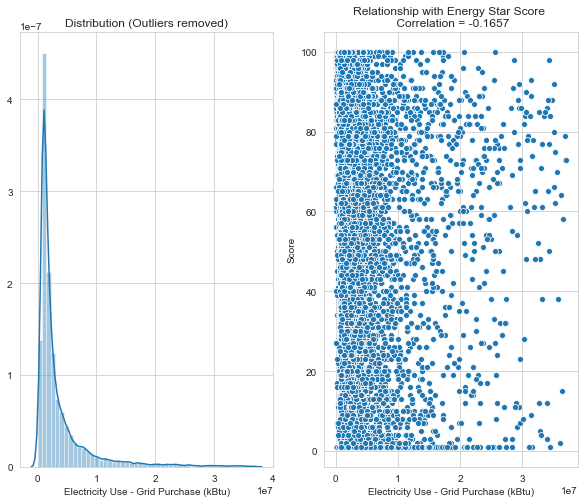

In [30]:
y_feature, feature = remove_outliers(df, 'Electricity Use - Grid Purchase (kBtu)')
num_plots(df, feature, y_feature)

In [31]:
collinear_features(df, 'Electricity Use - Grid Purchase (kBtu)')

,feature,correlation
0,Weather Normalized Site Electricity (kWh),0.999949


### 3. Preprocessing

#### 3.1 Drop Collinear Features

In [32]:
#feature pairs with a correlation of more than 0.9

corr_matrix = df.corr().abs()
high_corr_var = np.where(corr_matrix > 0.9)
high_corr_var = [(corr_matrix.columns[x],corr_matrix.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]
high_corr_var

[('Largest Property Use Type - Gross Floor Area (ft²)',
  'Property GFA - Self-Reported (ft²)'),
 ('Site EUI (kBtu/ft²)', 'Weather Normalized Site EUI (kBtu/ft²)'),
 ('Site EUI (kBtu/ft²)',
  'Weather Normalized Site Natural Gas Intensity (therms/ft²)'),
 ('Site EUI (kBtu/ft²)', 'Weather Normalized Source EUI (kBtu/ft²)'),
 ('Site EUI (kBtu/ft²)', 'Source EUI (kBtu/ft²)'),
 ('Weather Normalized Site EUI (kBtu/ft²)',
  'Weather Normalized Site Natural Gas Intensity (therms/ft²)'),
 ('Weather Normalized Site EUI (kBtu/ft²)',
  'Weather Normalized Source EUI (kBtu/ft²)'),
 ('Weather Normalized Site EUI (kBtu/ft²)', 'Source EUI (kBtu/ft²)'),
 ('Weather Normalized Site Natural Gas Intensity (therms/ft²)',
  'Weather Normalized Source EUI (kBtu/ft²)'),
 ('Weather Normalized Site Natural Gas Intensity (therms/ft²)',
  'Source EUI (kBtu/ft²)'),
 ('Weather Normalized Source EUI (kBtu/ft²)', 'Source EUI (kBtu/ft²)'),
 ('Natural Gas Use (kBtu)',
  'Weather Normalized Site Natural Gas Use (therms)

In [33]:
drop_cols = ['DOF Gross Floor Area', 'Weather Normalized Site EUI (kBtu/ft²)', 'Direct GHG Emissions (Metric Tons CO2e)', 'Property GFA - Self-Reported (ft²)', 'Weather Normalized Site Natural Gas Intensity (therms/ft²)', 'Source EUI (kBtu/ft²)', 'Site EUI (kBtu/ft²)', 'Weather Normalized Site Natural Gas Use (therms)', 'NTA', 'Year Built']
df.drop(columns=drop_cols, inplace=True)

#### 3.2 Missing Values / Scaling / One Hot Encoder

In [55]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

In [35]:
df.dropna(subset=['Score'], inplace=True)

In [36]:
class Preprocessing:
    df_num = df[['Largest Property Use Type - Gross Floor Area (ft²)', 'Number of Buildings - Self-reported',
                'Occupancy', 'Weather Normalized Site Electricity Intensity (kWh/ft²)', 'Weather Normalized Source EUI (kBtu/ft²)',
                'Natural Gas Use (kBtu)', 'Electricity Use - Grid Purchase (kBtu)',
                'Weather Normalized Site Electricity (kWh)', 'Total GHG Emissions (Metric Tons CO2e)',
                 'Indirect GHG Emissions (Metric Tons CO2e)'
                ]]
    
    df_cat = df[['Borough', 'Largest Property Use Type', 'year_cat']]
    
    def remove_outliers(self):
        result = 
    
    def num_transform(self):
        num_transform = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
        ])
        return num_transform
    
    def one_hot_transform(self):
        hot_transform = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])
        return hot_transform
    
    def preprocessor(self):
        num_transform = self.num_transform()
        hot_transform = self.one_hot_transform()
        
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', num_transform, list(self.df_num)),
                ('hot', hot_transform, list(self.df_cat))
            ]
        )
        return preprocessor

## 4. Models

In [53]:
class BaseModels:
    def __init__(self, X, y, models, preprocessor):
        self.X = X
        self.y = y
        self.models = models
        self.preprocessor = preprocessor
        
    def fit(self, model):
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=77)
        clf = Pipeline(steps=[
            ('preprocessor', self.preprocessor),
            ('classifier', model)
        ])
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        return rmse, y_pred
    
    def results(self):
        results = []
        models = []
        for model in self.models:
            rmse, y_pred = self.fit(model)
            results.append(rmse)
            models.append(str(model).split('(')[0])
        return results, models
    
    def plot_results(self):
        results, models = self.results()   
        plt.figure(figsize=(10, 5))
        g = sns.barplot(x=models, y=results, palette='Blues_d')
        g.set(ylabel='RMSE', title='Model Comparision by RMSE')
        for p in g.patches:
            g.annotate(format(p.get_height(), '.4f'), (p.get_x() + p.get_width() / 2., p.get_height() ),
            ha = 'center', va = 'center', xytext=(0,10), textcoords = 'offset points')
        plt.show()     

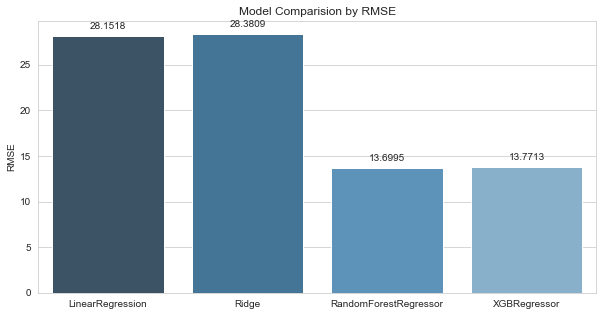

In [54]:
def run_base():
    preprocessor = Preprocessing().preprocessor()
    models = [LinearRegression(), Ridge(), RandomForestRegressor(), XGBRegressor()]
    X = df.drop(columns=['Score'])
    y = df['Score']
    BaseModels(X, y, models, preprocessor).plot_results()
    
run_base()

## 5. HyperParamter Tuning

In [59]:
class HyperParameterTuning:
    def __init__(self, X, y, preprocessor):
        self.X = X
        self.y = y
        self.preprocessor = preprocessor
        
    def fit_grid(self, model, grid):
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=77)
        grid_search = Pipeline(steps=[
            ('preprocessor', self.preprocessor),
            ('grid_search', GridSearchCV(estimator=model, param_grid=grid))
            ])
        grid_search.fit(X_train, y_train)
        best_params = grid_search.named_steps['grid_search'].best_params_
        return best_params, score
        
    def tune_rf(self):
        grid = {
            'max_depth': [20, 40, 60, 80, None],
            'max_features': ['auto', 'sqrt'],
            'min_samples_leaf': [1, 2, 4],
            'min_samples_split': [2, 5, 10],
            'n_estimators': [400, 600, 800, 100]
        }
        best_params = self.fit_grid(RandomForestRegressor(), grid)
        return best_params
    
    def tune_xgb(self):
        grid = {
            'learning_rate': [0.05, 0.10, 0.15, 0.2],
            'max_depth': [3, 4, 5, 6],
            'min_child_weight': [1, 3, 5, 7],
            'gamma': [0.00, 0.10, 0.20, 0.30]
        }
        best_params = self.fit_grid(XGBRegressor(), grid)
        return best_params

In [57]:
def best_params():
    preprocessor = Preprocessing().preprocessor()
    X = df.drop(columns=['Score'])
    y = df['Score']
    rf_params = HyperParameterTuning(X, y, preprocessor).tune_rf()
    xgb_params = HyperParameterTuning(X, y, preprocessor).tune_xgb()
    return rf_params, xgb_params

In [60]:
rf_params, xgb_params = best_params()

print('Best Hyperparameters (Random Forest):', rf_params)
print('\n\n')
print('Best Hyperparameters (XGB Regression):', xgb_params)

KeyboardInterrupt: 